In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import torch
# from heat_solver import solve_heat_equation
from heat_solver import HeatSolver
from utils import (
    verification_solution, verification_source, compute_l2_error, 
    compute_relative_error, visualize_solution, visualize_comparison, plot_convergence_analysis,
    print_solver_info, create_conductivity_field
)

In [85]:
device = 'cpu'

In [95]:
# Create conductivity field
M = 10
sigma = create_conductivity_field(M, pattern='constant')
sigma.requires_grad_(True)

solver = HeatSolver(sigma, M, verification_source, device)

# Solve heat equation
u_final, u_history = solver(T=1.0)

print(f"Final temperature range: [{u_final.min():.4f}, {u_final.max():.4f}]")

Final temperature range: [-0.6216, 0.6216]


In [96]:
h = 1.0 / M
x = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
y = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
X, Y = torch.meshgrid(x, y, indexing='ij')

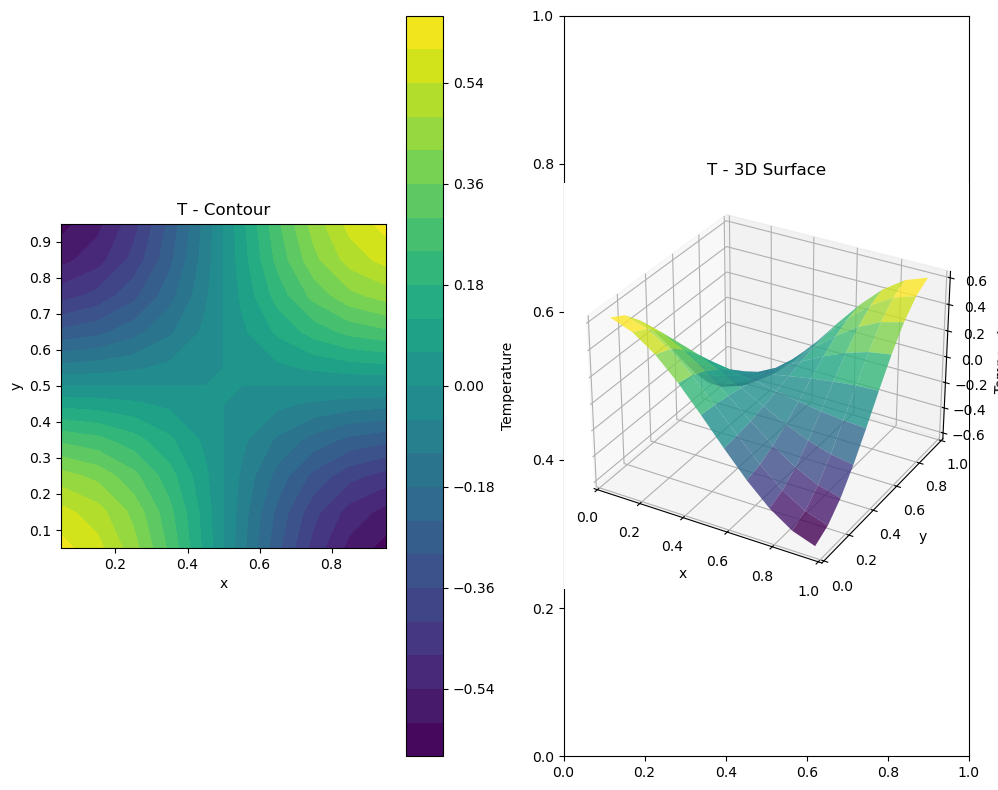

In [97]:
visualize_solution(u_final.detach().numpy(), X.detach().numpy(), Y.detach().numpy(), "T")

In [98]:
from inverse_solver import InverseSolver

In [99]:
u_final.shape

torch.Size([10, 10])

In [100]:
idx = torch.tensor([0, -1])
mask = torch.zeros((M, M), dtype=torch.bool)
mask[idx, :] = True
mask[:, idx] = True

u_b = u_history[:, mask]

In [101]:
u_b.shape

torch.Size([890, 36])

In [102]:
inv_solver = InverseSolver(
    M,
    u_final[mask].detach(),
    verification_source,
    T=0.2,
    alpha=0.1,
    sigma_0=1,
    device=device,
)

In [103]:
inv_solver.solve(max_iters=5, lr=0.01)

 20%|██        | 1/5 [00:10<00:43, 10.92s/it]

Iter 0: Loss = 0.094031


 40%|████      | 2/5 [00:22<00:34, 11.38s/it]

Iter 1: Loss = 0.093856


 60%|██████    | 3/5 [00:34<00:23, 11.76s/it]

Iter 2: Loss = 0.093685


 80%|████████  | 4/5 [00:46<00:11, 11.92s/it]

Iter 3: Loss = 0.093526


100%|██████████| 5/5 [00:58<00:00, 11.79s/it]

Iter 4: Loss = 0.093376


(array([[0.9500623 , 0.95010185, 0.9502336 , 0.95106816, 0.9913454 ,
         0.99134535, 0.95106816, 0.9502336 , 0.95010185, 0.9500623 ],
        [0.95010185, 0.95020217, 0.95050055, 0.95289487, 0.99874777,
         0.9987477 , 0.95289487, 0.95050055, 0.95020217, 0.95010185],
        [0.9502336 , 0.95050055, 0.9515018 , 0.9622652 , 1.0013837 ,
         1.0013835 , 0.9622652 , 0.9515018 , 0.95050055, 0.9502336 ],
        [0.95106816, 0.95289487, 0.9622652 , 0.9913283 , 1.0044843 ,
         1.0044843 , 0.9913283 , 0.9622652 , 0.95289487, 0.95106816],
        [0.9913454 , 0.99874777, 1.0013835 , 1.0044843 , 1.0059125 ,
         1.0059125 , 1.0044843 , 1.0013837 , 0.9987477 , 0.9913454 ],
        [0.99134535, 0.9987477 , 1.0013835 , 1.0044843 , 1.0059125 ,
         1.0059125 , 1.0044843 , 1.0013835 , 0.9987477 , 0.99134535],
        [0.95106816, 0.95289487, 0.9622652 , 0.9913283 , 1.0044843 ,
         1.0044843 , 0.9913283 , 0.96226513, 0.95289487, 0.95106816],
        [0.9502336 , 0.9505